# Objective:
To develop a customer segmentation to define marketing strategy and use the derived KPIs to gain insight on the customer profiles and provide the strategic insights and implementation of strategies.

---------------------------------------------------------------------------------------------------------------

# Impoting Packages

In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats # If want to run stat tests
from sklearn.cluster import KMeans # For running a K means algorithm
from sklearn.metrics import silhouette_score # For finding the silhouette_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler # For Standardization
from sklearn.decomposition import PCA   # For running PCA
from sklearn import metrics

In [341]:
#Writing output data into excel
output = pd.ExcelWriter('segmentation1.xlsx')

# Importing File

In [342]:
data = pd.read_csv('CC_GENERAL.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [343]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## UDF's

In [344]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [345]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [346]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

In [347]:
# Getting Continuous Variables
cont_var = data.select_dtypes(['int64','float64'])
cont_var.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [348]:
cont_col= ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE']

In [349]:
# Getting Categorical Variables
cat_var = data.select_dtypes(['object'])
cat_var.columns

Index(['CUST_ID'], dtype='object')

In [350]:
# dropping CUST_ID
data.drop(columns='CUST_ID',inplace=True)

In [351]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [352]:
#  Summary of continous var
cont_summary = data[cont_col].apply(continuous_var_summary).T
cont_summary.to_excel(output, 'Statistical Summary', startrow = 3)

In [272]:
# outlier Treatment
data[cont_col]=data[cont_col].apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))
data[cont_col].to_excel(output, 'Train Oulier Treatment')

In [353]:
# Missing Value Treatment
data[cont_col] =data[cont_col].apply(missing_imputation)
data[cont_col].to_excel(output, 'Missing', startrow = 3)

In [354]:
data[cont_col].isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [355]:
df=data[cont_col]
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Advanced data preparation

### Deriving KPI's

#### Monthly average purchase and cash advance amount

In [356]:
# monthly average purchase
df['MONTHLY_AVG_PURCHASE'] = df['PURCHASES']/df['TENURE']
df.MONTHLY_AVG_PURCHASE.head()

0      7.950000
1      0.000000
2     64.430833
3    124.916667
4      1.333333
Name: MONTHLY_AVG_PURCHASE, dtype: float64

In [357]:
# Cash Advance 
df['CASH_ADVANCE_AMT']=df['CASH_ADVANCE']/df['TENURE']
df.CASH_ADVANCE_AMT.head()

0      0.000000
1    536.912124
2      0.000000
3     17.149001
4      0.000000
Name: CASH_ADVANCE_AMT, dtype: float64

#### Purchase by type

In [358]:
df[["ONEOFF_PURCHASES","INSTALLMENTS_PURCHASES"]]

,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES
0,0.00,95.40
1,0.00,0.00
2,773.17,0.00
3,1499.00,0.00
4,16.00,0.00
...,...,...
8945,0.00,291.12
8946,0.00,300.00
8947,0.00,144.40
8948,0.00,0.00


In [359]:
df['PURCHASE_TYPE'] = np.where((df.ONEOFF_PURCHASES == 0)& (df.INSTALLMENTS_PURCHASES == 0), "None",
                                 np.where((df.ONEOFF_PURCHASES > 0)& (df.INSTALLMENTS_PURCHASES == 0),"One_of_Purchase",
                                         np.where((df.ONEOFF_PURCHASES == 0)& (df.INSTALLMENTS_PURCHASES > 0),"Installment_Purchases",
                                                 np.where((df.ONEOFF_PURCHASES > 0)& (df.INSTALLMENTS_PURCHASES > 0),"Both",""))))

#### limit usage(Balance to Credit Limit ratio)

In [360]:
df['LIMIT_USAGE'] = df['BALANCE']/df['CREDIT_LIMIT']

#### Payments to minimum payments ratio

In [361]:
df['PAYMENT_MINPAY'] = df['PAYMENTS']/df['MINIMUM_PAYMENTS']

## Advanced Reporting

#### Insights using derived KPIs

In [362]:
df.groupby('PURCHASE_TYPE')[['MONTHLY_AVG_PURCHASE','CASH_ADVANCE_AMT','LIMIT_USAGE','PAYMENT_MINPAY']].mean()

,MONTHLY_AVG_PURCHASE,CASH_ADVANCE_AMT,LIMIT_USAGE,PAYMENT_MINPAY
PURCHASE_TYPE,,,,
Both,192.685172,67.821985,0.353548,7.231176
Installment_Purchases,46.974347,38.398206,0.271678,13.245074
None,0.000000,182.858169,0.573770,10.076701
One_of_Purchase,69.688958,78.995966,0.381074,5.498136


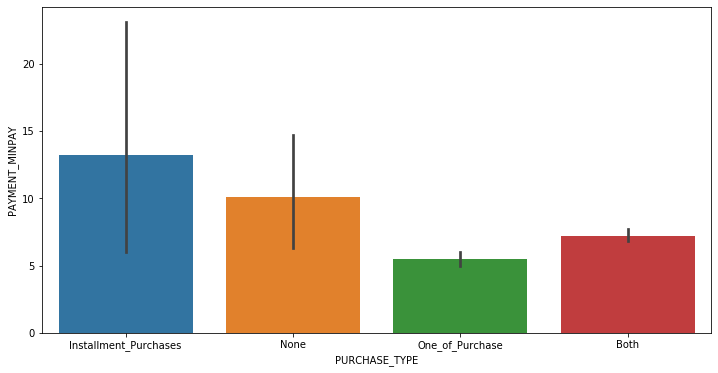

In [363]:
plt.figure(figsize=(12,6))
sns.barplot(x="PURCHASE_TYPE", y="PAYMENT_MINPAY", data=df)
plt.show()

<b> Customer with Both puchase type mode are higher

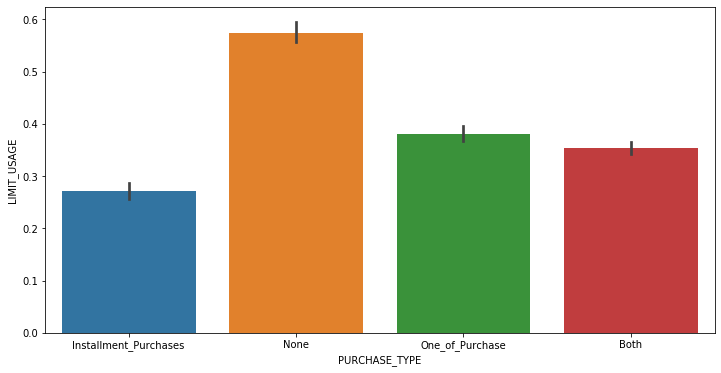

In [364]:
plt.figure(figsize=(12,6))
sns.barplot(x="PURCHASE_TYPE", y="LIMIT_USAGE", data=df)
plt.show()

<b> Customers who don't do either one-off or installment purchases are higher

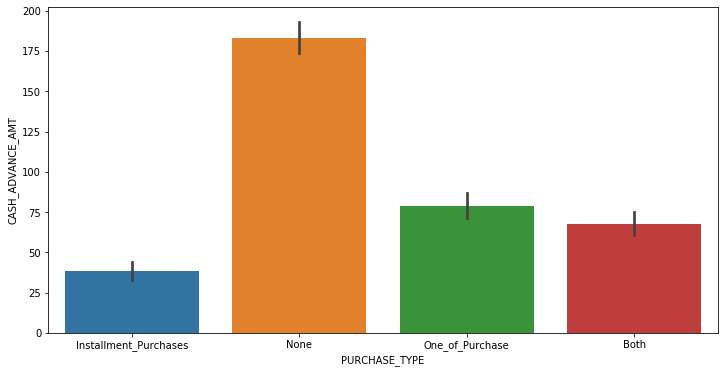

In [365]:
plt.figure(figsize=(12,6))
sns.barplot(x="PURCHASE_TYPE", y="CASH_ADVANCE_AMT", data=df)
plt.show()

<b> Customers who don't do either one-off or installment purchases are higher

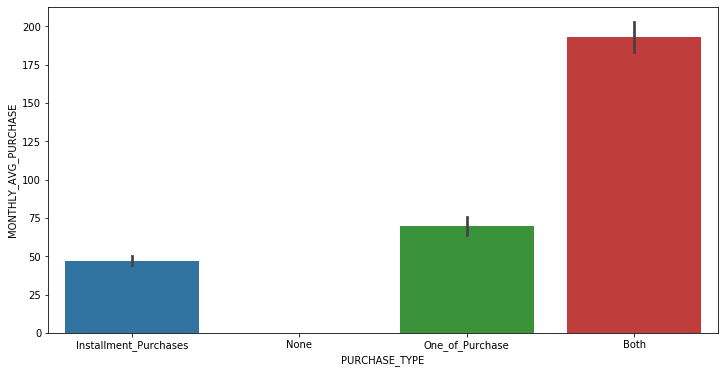

In [366]:
plt.figure(figsize=(12,6))
sns.barplot(x="PURCHASE_TYPE", y="MONTHLY_AVG_PURCHASE", data=df)
plt.show()

<b> Customer doing Purchase Type by both modes are higher

In [367]:
# Creating Dummy for the Purchase_Type

In [369]:
df = pd.get_dummies(df, columns=['PURCHASE_TYPE'], drop_first=True)

In [370]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVG_PURCHASE,CASH_ADVANCE_AMT,LIMIT_USAGE,PAYMENT_MINPAY,PURCHASE_TYPE_Installment_Purchases,PURCHASE_TYPE_None,PURCHASE_TYPE_One_of_Purchase
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,139.509787,0.000000,12,7.950000,0.000000,0.040901,1.446508,1,0,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,1072.340217,0.222222,12,0.000000,536.912124,0.457495,3.826241,0,1,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,627.284787,0.000000,12,64.430833,0.000000,0.332687,0.991682,0,0,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,864.206542,0.000000,12,124.916667,17.149001,0.222223,0.000000,0,0,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,244.791237,0.000000,12,1.333333,0.000000,0.681429,2.771075,0,0,1


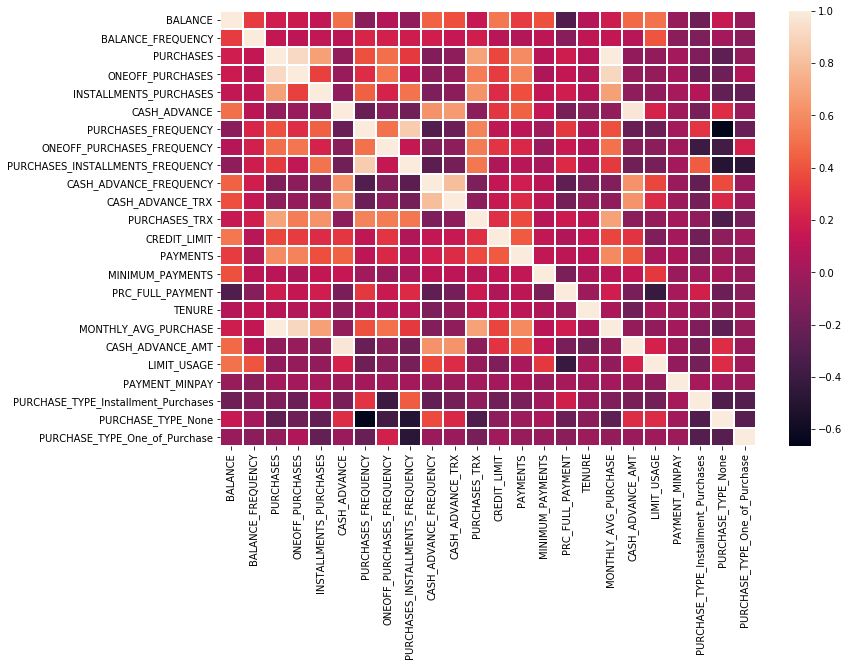

In [371]:
#Correlation matrix heatmap of train dataset
cm = df.corr()
cm.to_excel(output, 'Correlation Matrix')

plt.figure(figsize = (12,8))
sns.heatmap(cm, linewidths = 1)
plt.show()

## Standardising the data

In [372]:
sc = StandardScaler()

In [373]:
scaled_data = sc.fit(df)

In [374]:
scaled_data = scaled_data.transform(df)

In [375]:
scaled_data=pd.DataFrame(scaled_data, columns=df.columns)

In [376]:
scaled_data

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVG_PURCHASE,CASH_ADVANCE_AMT,LIMIT_USAGE,PAYMENT_MINPAY,PURCHASE_TYPE_Installment_Purchases,PURCHASE_TYPE_None,PURCHASE_TYPE_One_of_Purchase
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,...,-3.109675e-01,-0.525551,0.360680,-0.433384,-0.460727,-0.892950,-0.064226,1.720516,-0.543690,-0.514625
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,...,8.931021e-02,0.234227,0.360680,-0.477428,2.319396,0.176063,-0.044088,-0.581221,1.839282,-0.514625
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,...,-1.016632e-01,-0.525551,0.360680,-0.120468,-0.460727,-0.144206,-0.068075,-0.581221,-0.543690,1.943162
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,...,-4.390474e-16,-0.525551,0.360680,0.214636,-0.371929,-0.427664,-0.076467,-0.581221,-0.543690,1.943162
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,...,-2.657913e-01,-0.525551,0.360680,-0.470041,-0.460727,0.750693,-0.053017,-0.581221,-0.543690,1.943162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-0.737950,0.518084,-0.333293,-0.356934,-0.132643,-0.466786,1.269843,-0.678661,1.179833,-0.675349,...,-3.498541e-01,1.183951,-4.122768,-0.208617,-0.460727,-0.924788,-0.020106,1.720516,-0.543690,-0.514625
8946,-0.742423,0.518084,-0.329136,-0.356934,-0.122823,-0.466786,1.269843,-0.678661,1.179833,-0.675349,...,-4.390474e-16,-0.525551,-4.122768,-0.200418,-0.460727,-0.948679,-0.073766,1.720516,-0.543690,-0.514625
8947,-0.740398,-0.185477,-0.401965,-0.356934,-0.294893,-0.466786,0.854576,-0.678661,0.760469,-0.675349,...,-3.354655e-01,0.329200,-4.122768,-0.344094,-0.460727,-0.937862,-0.068122,1.720516,-0.543690,-0.514625
8948,-0.745174,-0.185477,-0.469552,-0.356934,-0.454576,-0.449352,-1.221758,-0.678661,-0.916995,0.157527,...,-3.469065e-01,0.329200,-4.122768,-0.477428,-0.429177,-0.928838,-0.068491,-0.581221,1.839282,-0.514625


In [377]:
scaled_data.to_excel(output, 'Standaridized Data')

In [378]:
scaled_data.describe().T[['std','mean']]

# std is 1 in all case
# mean is almost 0
# that means data is standardised

,std,mean
BALANCE,1.000056,4.195651e-16
BALANCE_FREQUENCY,1.000056,1.209548e-14
PURCHASES,1.000056,-9.278518e-16
ONEOFF_PURCHASES,1.000056,3.916048e-15
INSTALLMENTS_PURCHASES,1.000056,2.275424e-15
CASH_ADVANCE,1.000056,5.697020e-15
PURCHASES_FREQUENCY,1.000056,-3.716084e-16
ONEOFF_PURCHASES_FREQUENCY,1.000056,2.021052e-15
PURCHASES_INSTALLMENTS_FREQUENCY,1.000056,2.353921e-16
CASH_ADVANCE_FREQUENCY,1.000056,5.856519e-16


## PCA

In [379]:
from sklearn.decomposition import PCA


In [380]:
# Intialize the model 
pca_model = PCA()

In [381]:
# Fitting the model on the scaled dataset
pca_model = pca_model.fit(scaled_data)

In [382]:
# Amount of variance explained by each Principal Compoenet aka Eigen Value
eigen_value=pca_model.explained_variance_
eigen_value

array([5.71374279e+00, 4.59220913e+00, 2.16972571e+00, 1.76429918e+00,
       1.39026207e+00, 1.15362757e+00, 1.04113440e+00, 9.87693052e-01,
       8.29809336e-01, 7.40556270e-01, 6.76716367e-01, 5.82107500e-01,
       5.58039250e-01, 4.26684889e-01, 3.07421360e-01, 2.65060816e-01,
       2.43711253e-01, 1.80084760e-01, 1.72471906e-01, 1.50614358e-01,
       3.60898811e-02, 1.62218360e-02, 4.38655276e-03, 1.16245049e-05])

In [383]:
# Cummulative variance by eigen values 
cumm_var = np.cumsum(pca_model.explained_variance_ratio_)*100
cumm_var

array([ 23.80460158,  42.93666839,  51.97618207,  59.32660729,
        65.1187187 ,  69.92496318,  74.26253847,  78.37746637,
        81.83461895,  84.91992531,  87.7392618 ,  90.16443871,
        92.48934246,  94.26699752,  95.54777673,  96.6520734 ,
        97.66742349,  98.41769282,  99.13624547,  99.76373517,
        99.91409288,  99.98167631,  99.99995157, 100.        ])

In [384]:
eigen_cummvar=pd.DataFrame({'Eigen_value': eigen_value, 'Cumm_variance':cumm_var},).round(4)
eigen_cummvar

,Eigen_value,Cumm_variance
0,5.7137,23.8046
1,4.5922,42.9367
2,2.1697,51.9762
3,1.7643,59.3266
4,1.3903,65.1187
5,1.1536,69.9250
6,1.0411,74.2625
7,0.9877,78.3775
8,0.8298,81.8346
9,0.7406,84.9199


<b>Since 7 Components explains 81% variance of the data, we select 7 components.

In [385]:
# Initializing the model with 7 components
pca = PCA(n_components=7)

In [386]:
# applying it on scaled data
final_pca = pca.fit(scaled_data)

In [387]:
# Variance explained by these components
eigen_value2 = final_pca.explained_variance_

In [388]:
# Cummulative Variance
cumm_var2 = np.cumsum(final_pca.explained_variance_ratio_)

In [389]:
eigen_cummvar2=pd.DataFrame({'Eigen_value': eigen_value2, 'Cumm_variance':cumm_var2},).round(4)
eigen_cummvar2

,Eigen_value,Cumm_variance
0,5.7137,0.2380
1,4.5922,0.4294
2,2.1697,0.5198
3,1.7643,0.5933
4,1.3903,0.6512
5,1.1536,0.6992
6,1.0411,0.7426


In [390]:
eigen_cummvar2.to_excel(output, 'Eigen value & Cummulative Var')

### Factor Loading

In [391]:
pc = PCA(n_components = 7)
reduced_cr = pc.fit_transform(scaled_data)
pc_data = pd.DataFrame(reduced_cr)
pc_data.head()

,0,1,2,3,4,5,6
0,-1.195472,-2.023360,-0.320055,-0.284325,0.610143,0.543215,0.217010
1,-2.142088,3.161781,-0.278599,-1.344050,0.715421,0.505308,-1.084023
2,0.907814,-0.316217,2.108299,1.169617,-2.598101,0.497770,-0.280758
3,-0.574231,-0.291911,2.372314,-0.107024,-0.323036,1.453679,0.551533
4,-1.501369,-0.860656,1.736042,1.258585,-0.628782,0.275951,0.495921


In [392]:
#Principal Componenet Data
pca = pd.DataFrame(pc.components_.T, columns = ['PC_' + str(i) for i in range(7)], index = scaled_data.columns)
pca

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
BALANCE,0.028144,0.351895,-0.092557,0.229519,-0.032322,0.259457,0.023537
BALANCE_FREQUENCY,0.072677,0.140176,-0.141831,0.415690,-0.183677,-0.286423,-0.235813
PURCHASES,0.369593,0.119647,0.141835,-0.021231,0.209408,-0.057565,0.100835
ONEOFF_PURCHASES,0.312293,0.128703,0.266735,-0.031116,0.149273,-0.081301,0.101949
INSTALLMENTS_PURCHASES,0.300090,0.046369,-0.154673,0.006895,0.220905,0.013293,0.051209
CASH_ADVANCE,-0.085287,0.375576,-0.151342,-0.257641,-0.138000,0.055354,0.002483
PURCHASES_FREQUENCY,0.304014,-0.117270,-0.281304,0.041804,-0.323316,-0.087731,0.007780
ONEOFF_PURCHASES_FREQUENCY,0.258750,0.050823,0.251820,0.075325,-0.379205,-0.167133,-0.120493
PURCHASES_INSTALLMENTS_FREQUENCY,0.259140,-0.117090,-0.448657,0.023819,-0.085451,-0.060766,-0.019764
CASH_ADVANCE_FREQUENCY,-0.137538,0.344658,-0.105021,-0.061758,-0.093551,-0.230611,-0.001825


In [393]:
pca.to_excel(output, 'PCA')

In [394]:
#Variance explained by each component
pd.Series(pc.explained_variance_ratio_,index=['PC_'+ str(i) for i in range(7)])

PC_0    0.238046
PC_1    0.191321
PC_2    0.090395
PC_3    0.073504
PC_4    0.057921
PC_5    0.048062
PC_6    0.043376
dtype: float64

# Clustering

In [395]:
# Initialize the model
km_4 = KMeans(n_clusters=4, random_state=123)

In [396]:
km_4.fit(reduced_cr)

KMeans(n_clusters=4, random_state=123)

In [397]:
km_4.labels_

array([3, 2, 0, ..., 3, 0, 0])

In [398]:
len(km_4.cluster_centers_[0])

7

In [399]:
pd.Series(km_4.labels_).value_counts()

3    3792
0    3512
2    1024
1     622
dtype: int64

In [400]:
# Identifying the range of K
# Calculating Silhouette Score for K = 3 to 8
k_range = range(3,9)
scores = []
for k in k_range :
    km = KMeans(n_clusters = k, random_state = 123)
    km.fit(reduced_cr)
    scores.append(silhouette_score(reduced_cr,km.labels_))

In [401]:
scores

[0.2589575957991596,
 0.23747897271131096,
 0.2752805475780736,
 0.2815105527930423,
 0.26673429927200665,
 0.2701264322350386]

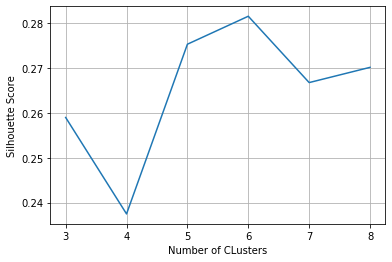

In [402]:
#Plotting the results
plt.plot(k_range, scores)
plt.xlabel('Number of CLusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

In [403]:
#Based of Silhouette Score, optimal value of k lies between 5 to 7

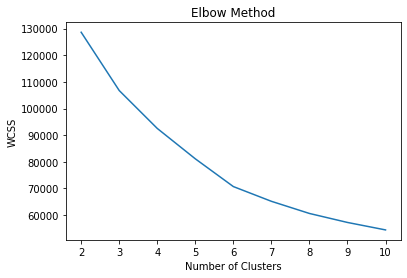

In [404]:
#Pseudo F-Score(Elbow Method)
wcss = []
for i in range(2,11):
    km = KMeans(n_clusters = i, random_state = 123)
    km.fit(reduced_cr)
    wcss.append(km.inertia_)
plt.plot(range(2,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [405]:
# Based of Pseudo F-Score, optimal k value lies between 3 to 5

In [406]:
# Final range that we can try is 3 to 8

In [407]:
#Building Cluster with k value from 3 to 7
km_3 = KMeans(n_clusters = 3, random_state = 123).fit(reduced_cr)
km_4 = KMeans(n_clusters = 4, random_state = 123).fit(reduced_cr)
km_5 = KMeans(n_clusters = 5, random_state = 123).fit(reduced_cr)
km_6 = KMeans(n_clusters = 6, random_state = 123).fit(reduced_cr)
km_7 = KMeans(n_clusters = 7, random_state = 123).fit(reduced_cr)
km_8 = KMeans(n_clusters = 8, random_state = 123).fit(reduced_cr)

In [408]:
df['Cluster_3'] = km_3.labels_
df['Cluster_4'] = km_4.labels_
df['Cluster_5'] = km_5.labels_
df['Cluster_6'] = km_6.labels_
df['Cluster_7'] = km_7.labels_
df['Cluster_8'] = km_8.labels_

In [409]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PAYMENT_MINPAY,PURCHASE_TYPE_Installment_Purchases,PURCHASE_TYPE_None,PURCHASE_TYPE_One_of_Purchase,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,1.446508,1,0,0,1,3,3,1,6,2
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,3.826241,0,1,0,0,2,2,4,0,6
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.991682,0,0,1,1,0,0,2,1,4
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.000000,0,0,1,1,0,0,2,1,4
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,2.771075,0,0,1,1,0,0,2,1,4


## Creating a DataFrame for Manual Profiling

In [410]:
#Creating Profile DataFrame
profile = pd.concat([df.apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_3').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_4').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_5').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_6').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_7').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_8').apply(lambda x: x.mean()).T],
                     axis = 1, )

In [411]:
#Naming Profile Columns
profile.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                              'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                              'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                              'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5', 'KM6_6',
                              'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5', 'KM7_6', 'KM7_7',
                              'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8']

In [412]:
profile

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
BALANCE,1564.474828,2626.882708,774.179936,3114.037078,1298.640232,2984.855057,4678.315128,736.827710,1111.110255,3033.534818,...,5708.352229,491.091698,3667.006798,1970.524089,108.586130,1687.511470,1054.703591,5870.895179,5256.559993,1185.168374
BALANCE_FREQUENCY,0.877271,0.911343,0.844293,0.983833,0.845582,0.984396,0.960397,0.866600,0.826365,0.986109,...,0.952525,0.801162,0.988245,0.988650,0.738779,0.875220,0.812154,0.950699,0.960965,0.973087
PURCHASES,1003.204834,173.250617,802.861361,5885.521036,311.761387,6300.900772,519.732441,905.171669,675.289384,6427.782357,...,26258.526667,494.066576,7042.931020,675.706792,497.221786,6.181326,570.158989,26706.744231,639.697428,2289.480840
ONEOFF_PURCHASES,592.437371,120.803800,411.706335,3865.228137,295.669431,4192.010772,325.718867,348.880963,662.322633,4235.443805,...,19222.042963,19.191641,4545.923717,200.838640,36.095177,4.135376,561.740241,19866.124231,406.713767,1423.470683
INSTALLMENTS_PURCHASES,411.067645,52.481684,391.528139,2021.133235,16.219485,2109.854630,194.112861,556.696055,13.210353,2193.348653,...,7036.483704,475.537655,2498.980987,475.214494,461.737771,2.045950,8.656312,6840.620000,233.084947,866.048619
CASH_ADVANCE,978.871112,2442.548268,173.109197,1004.880644,704.820792,512.775705,5123.684912,189.864450,399.587390,519.408577,...,953.157982,164.125520,651.003177,653.868991,37.546496,1341.788079,424.433206,989.817905,6248.099150,226.164049
PURCHASES_FREQUENCY,0.490351,0.117504,0.633480,0.946611,0.161909,0.945934,0.292478,0.773245,0.333407,0.948780,...,0.900617,0.700796,0.946606,0.693446,0.694344,0.004234,0.297528,0.896795,0.327389,0.911012
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.061347,0.212001,0.707657,0.142284,0.729188,0.142708,0.187924,0.323131,0.727710,...,0.764198,0.012678,0.728499,0.118250,0.019228,0.002033,0.289002,0.771154,0.167537,0.595503
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.063476,0.474446,0.773900,0.022638,0.758102,0.191237,0.663198,0.016957,0.782614,...,0.730247,0.658357,0.787610,0.610993,0.646973,0.002490,0.010108,0.719872,0.212253,0.676788
CASH_ADVANCE_FREQUENCY,0.135144,0.319664,0.038613,0.100813,0.146344,0.064866,0.496545,0.038706,0.082022,0.065233,...,0.037037,0.029183,0.078369,0.125960,0.006662,0.238763,0.087111,0.038462,0.544199,0.046225


In [413]:
#Getting size of clusters
size = pd.concat([pd.Series(len(df)),
                  pd.Series.sort_index(df.Cluster_3.value_counts()),
                  pd.Series.sort_index(df.Cluster_4.value_counts()),
                  pd.Series.sort_index(df.Cluster_5.value_counts()),
                  pd.Series.sort_index(df.Cluster_6.value_counts()),
                  pd.Series.sort_index(df.Cluster_7.value_counts()),
                  pd.Series.sort_index(df.Cluster_8.value_counts())])

size = pd.DataFrame(size.reset_index(drop = True), columns = ['Seg_size'])
size.T

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Seg_size,8950,2916,5320,714,3512,622,1024,3792,1899,594,...,27,2316,304,1353,1781,1810,1741,26,661,1274


In [414]:
#Getting cluster percentage
seg_per = pd.DataFrame((size.values/df.Cluster_3.size), columns = ['Seg_perc'])
seg_per.T

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Seg_perc,1.0,0.32581,0.594413,0.079777,0.392402,0.069497,0.114413,0.423687,0.212179,0.066369,...,0.003017,0.258771,0.033966,0.151173,0.198994,0.202235,0.194525,0.002905,0.073855,0.142346


In [415]:
size_perc = pd.concat([size.T, seg_per.T])
size_perc.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                              'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                              'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                              'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5', 'KM6_6',
                              'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5', 'KM7_6', 'KM7_7',
                              'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8']

In [416]:
size_perc

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.0,2916.00000,5320.000000,714.000000,3512.000000,622.000000,1024.000000,3792.000000,1899.000000,594.000000,...,27.000000,2316.000000,304.000000,1353.000000,1781.000000,1810.000000,1741.000000,26.000000,661.000000,1274.000000
Seg_perc,1.0,0.32581,0.594413,0.079777,0.392402,0.069497,0.114413,0.423687,0.212179,0.066369,...,0.003017,0.258771,0.033966,0.151173,0.198994,0.202235,0.194525,0.002905,0.073855,0.142346


In [417]:
profile_final = pd.concat([size_perc, profile])
profile_final.to_excel(output, 'Profiling_output')
profile_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,2916.000000,5320.000000,714.000000,3512.000000,622.000000,1024.000000,3792.000000,1899.000000,594.000000,...,27.000000,2316.000000,304.000000,1353.000000,1781.000000,1810.000000,1741.000000,26.000000,661.000000,1274.000000
Seg_perc,1.000000,0.325810,0.594413,0.079777,0.392402,0.069497,0.114413,0.423687,0.212179,0.066369,...,0.003017,0.258771,0.033966,0.151173,0.198994,0.202235,0.194525,0.002905,0.073855,0.142346
BALANCE,1564.474828,2626.882708,774.179936,3114.037078,1298.640232,2984.855057,4678.315128,736.827710,1111.110255,3033.534818,...,5708.352229,491.091698,3667.006798,1970.524089,108.586130,1687.511470,1054.703591,5870.895179,5256.559993,1185.168374
BALANCE_FREQUENCY,0.877271,0.911343,0.844293,0.983833,0.845582,0.984396,0.960397,0.866600,0.826365,0.986109,...,0.952525,0.801162,0.988245,0.988650,0.738779,0.875220,0.812154,0.950699,0.960965,0.973087
PURCHASES,1003.204834,173.250617,802.861361,5885.521036,311.761387,6300.900772,519.732441,905.171669,675.289384,6427.782357,...,26258.526667,494.066576,7042.931020,675.706792,497.221786,6.181326,570.158989,26706.744231,639.697428,2289.480840
ONEOFF_PURCHASES,592.437371,120.803800,411.706335,3865.228137,295.669431,4192.010772,325.718867,348.880963,662.322633,4235.443805,...,19222.042963,19.191641,4545.923717,200.838640,36.095177,4.135376,561.740241,19866.124231,406.713767,1423.470683
INSTALLMENTS_PURCHASES,411.067645,52.481684,391.528139,2021.133235,16.219485,2109.854630,194.112861,556.696055,13.210353,2193.348653,...,7036.483704,475.537655,2498.980987,475.214494,461.737771,2.045950,8.656312,6840.620000,233.084947,866.048619
CASH_ADVANCE,978.871112,2442.548268,173.109197,1004.880644,704.820792,512.775705,5123.684912,189.864450,399.587390,519.408577,...,953.157982,164.125520,651.003177,653.868991,37.546496,1341.788079,424.433206,989.817905,6248.099150,226.164049
PURCHASES_FREQUENCY,0.490351,0.117504,0.633480,0.946611,0.161909,0.945934,0.292478,0.773245,0.333407,0.948780,...,0.900617,0.700796,0.946606,0.693446,0.694344,0.004234,0.297528,0.896795,0.327389,0.911012
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.061347,0.212001,0.707657,0.142284,0.729188,0.142708,0.187924,0.323131,0.727710,...,0.764198,0.012678,0.728499,0.118250,0.019228,0.002033,0.289002,0.771154,0.167537,0.595503


In [418]:
output.save()